# Linear Discriminant Analysis on Fashion MNIST Dataset

- Linear Discriminant Analysis (LDA) is a popular technique for dimensionality reduction and classification.

- In this notebook, we apply LDA to the Fashion MNIST dataset, a collection of clothing images, to classify them into their respective categories.

- Dimensionality reduction is particularly crucial in machine learning for high-dimensional data like images, as it helps to simplify models, reduce computational costs, and improve performance. Our goal is to explore the effectiveness of LDA for image classification and compare it with other techniques.

## Importing Necessary Libraries

First, we import the essential libraries required for data manipulation, visualization, and machine learning algorithms.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
from sklearn.svm import SVC

# TensorFlow/Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Dense,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


## Dataset Preparation

The Fashion MNIST dataset is loaded and preprocessed for analysis. This includes feature scaling and data labeling.

In [ ]:
# Loading the Fashion MNIST Dataset
dataset_train = np.load('fashion_train.npy')
X_train, y_train = dataset_train[:, :-1], dataset_train[:, -1]
dataset_test = np.load('fashion_test.npy')
X_test, y_test = dataset_test[:, :-1], dataset_test[:, -1]

# Normalize pixel values to be between 0 and 1 for efficiency
X_train = X_train / 255.0
X_test = X_test / 255.0

## Exploratory Data Analysis (EDA)

We conduct an EDA to gain insights into the dataset, focusing on the image types, their categories, class distribution, and pixel intensities.


In [ ]:
# Visualizing sample images from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.colorbar()
plt.suptitle('Sample Images from Fashion MNIST Dataset')
plt.show()

# Class Distribution Analysis
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Distribution in Fashion MNIST Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(unique, ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt'])
plt.show()



**Explore Feature Correlations:**

In [ ]:
# Visualize the correlation matrix of the features
corr_matrix = pd.DataFrame(X_train).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
#Not sure if this is needed, but it's here if we want it

## Custom LDA Implementation

We develop a custom LDA class with detailed comments on each function, aiming to provide a deep understanding of the algorithm's inner workings.


In [ ]:
# WARNING: This code is a placeholder and should be replaced with the final implementation by Bogdan.
class LDA_Custom:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eigenvectors_ = None

    def fit(self, X, y):
        self.classes_, y_indices = np.unique(y, return_inverse=True)
        self.class_means_ = np.array([X[y == label].mean(axis=0) for label in self.classes_])
        self.overall_mean_ = np.mean(X, axis=0)

        # Within-class scatter matrix
        scatter_within = np.sum([np.cov(X[y == label].T, bias=True) * len(X[y == label]) for label in self.classes_], axis=0)

        # Between-class scatter matrix
        scatter_between = np.sum([len(X[y == label]) * np.outer(self.class_means_[label] - self.overall_mean_, self.class_means_[label] - self.overall_mean_) for label in self.classes_], axis=0)

        # Solve the eigenvalue problem for inv(S_w).dot(S_b)
        eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(scatter_within).dot(scatter_between))

        # Normalize the eigenvectors (each eigenvector has a unit norm)
        eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0, keepdims=True)

        # Take the real parts of eigenvalues and eigenvectors if necessary
        eigenvalues = np.real(eigenvalues)
        eigenvectors = np.real(eigenvectors)

        # Sort eigenvectors by eigenvalues in descending order
        idx = np.argsort(-eigenvalues)
        self.eigenvectors_ = eigenvectors[:, idx]  # Assign to the attribute with underscore

        # Only take up to the number of components specified
        if self.n_components is not None:
            self.eigenvectors_ = self.eigenvectors_[:, :self.n_components]
        else:
            # Default to the number of classes minus 1 if n_components is not specified
            self.n_components = len(self.classes_) - 1
            self.eigenvectors_ = self.eigenvectors_[:, :self.n_components]

        return self

    def transform(self, X):
        if self.eigenvectors_ is None:
            raise RuntimeError("The model has not been fitted yet. Call 'fit' with appropriate arguments before using this method.")
        return X.dot(self.eigenvectors_)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

    def align_eigenvectors(self, reference_eigenvectors):
        for i in range(self.eigenvectors_.shape[1]):
            dot_product = np.dot(self.eigenvectors_[:, i], reference_eigenvectors[:, i])
            if dot_product < 0:
                self.eigenvectors_[:, i] *= -1

## Model Training and Transformation

Training the custom LDA model and transforming features into a lower-dimensional space to analyze the classification effectiveness.


In [ ]:
# Function to train and transform data using LDA
def lda_training_transformation(X, y, n_components=2):# Choosing 2 components for visualization in a 2D plot
    lda_custom = LDA_Custom(n_components)
    lda_custom.fit(X, y)
    return lda_custom.transform(X)

# Using Custom LDA
X_lda_custom = lda_training_transformation(X_train, y_train)

# Using Scikit-Learn's LDA for comparison
lda_sklearn = LinearDiscriminantAnalysis(n_components=2, solver='eigen')
lda_sklearn.fit(X_train, y_train)
X_lda_sklearn = lda_sklearn.transform(X_train)

## Visualizing LDA Transformation

Visualization of the LDA-transformed dataset to understand how different clothing categories are separated.


In [ ]:
def plot_lda(X, y, title, ax):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=sns.color_palette('hsv', np.unique(y).size), ax=ax)
    ax.set_title(title)
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
plot_lda(X_lda_custom, y_train, 'Custom LDA Projection', ax[0])
plot_lda(X_lda_sklearn, y_train, 'Scikit-Learn LDA Projection', ax[1])
plt.suptitle('2D Projections of Fashion MNIST using LDA')
plt.show()

**LDA cross validation**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import numpy as np

# Cross Validation for LDA Sklearn
lda_sklearn = LinearDiscriminantAnalysis(solver='eigen')
params = {'n_components': np.arange(1, 10)}
lda_sklearn_cv = GridSearchCV(lda_sklearn, params, cv=5)
lda_sklearn_cv.fit(X_train, y_train)
print(f"Best n_components: {lda_sklearn_cv.best_params_['n_components']}")
print(f"Best accuracy: {lda_sklearn_cv.best_score_}")


## LDA vs PCA Comparison

Comparing the LDA with Principal Component Analysis (PCA) to evaluate their effectiveness in class separability and feature representation.


### Theoretical Discussion:

#### Feature Scaling in LDA:
LDA is a supervised dimensionality reduction technique that aims to maximize the separation between classes while minimizing the variance within each class. Feature scaling is crucial in LDA for the following reasons:

1. **Equal Importance:** LDA assumes that features have equal importance in discriminating between classes. If the features have different scales, those with larger scales can dominate the variance and influence the LDA projection more than others. Scaling ensures that all features contribute equally to the analysis.

2. **Covariance Matrix:** LDA relies on the covariance matrix between classes and within classes. If the features are on different scales, the covariance estimates can be biased, leading to suboptimal discrimination.

#### Feature Scaling in PCA:
PCA, on the other hand, is an unsupervised dimensionality reduction technique that aims to capture the maximum variance in the data. Feature scaling is essential in PCA for the following reasons:

1. **Magnitude of Variance:** PCA operates by finding the directions (principal components) of maximum variance. Features with larger scales will inherently have larger variances and will dominate the principal components. Scaling ensures that all features have an equal opportunity to contribute to the principal components.

2. **Numerical Stability:** Large-scale differences in feature values can lead to numerical instability when computing the covariance matrix, which can affect the accuracy of the principal components.


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply Scikit-Learn LDA to get reference eigenvectors
lda_sklearn = LinearDiscriminantAnalysis(n_components=2)
X_lda_sklearn_unscaled = lda_sklearn.fit_transform(X_train, y_train)
X_lda_sklearn_scaled = lda_sklearn.fit_transform(X_train_scaled, y_train)

# Apply Custom LDA
lda_custom = LDA_Custom(n_components=2)
lda_custom.fit(X_train, y_train)  # Fit the custom LDA on unscaled data
# Align the eigenvectors of the custom LDA with Scikit-Learn's LDA (unscaled)
lda_custom.align_eigenvectors(lda_sklearn.scalings_[:, :2])
X_lda_custom_unscaled = lda_custom.transform(X_train)

lda_custom.fit(X_train_scaled, y_train)  # Fit the custom LDA on scaled data
# Align the eigenvectors of the custom LDA with Scikit-Learn's LDA (scaled)
lda_custom.align_eigenvectors(lda_sklearn.scalings_[:, :2])
X_lda_custom_scaled = lda_custom.transform(X_train_scaled)

# Apply PCA
pca = PCA(n_components=2)
X_pca_unscaled = pca.fit_transform(X_train)
X_pca_scaled = pca.fit_transform(X_train_scaled)

# Function to plot transformed data and centroids
def plot_transformed_data_and_centroids(X, y, title, ax):
    # Plot transformed data points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', ax=ax)
    
    # Calculate and plot centroids
    for label in np.unique(y):
        centroid = np.mean(X[y == label], axis=0)
        ax.scatter(centroid[0], centroid[1], s=100, c='black', marker='X')
    
    ax.set_title(title)
    ax.legend(loc='best')

# Visualization with centroids
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

plot_transformed_data_and_centroids(X_lda_custom_unscaled, y_train, 'Custom LDA (Unscaled)', axes[0, 0])
plot_transformed_data_and_centroids(X_lda_custom_scaled, y_train, 'Custom LDA (Scaled)', axes[0, 1])
plot_transformed_data_and_centroids(X_lda_sklearn_unscaled, y_train, 'Scikit-Learn LDA (Unscaled)', axes[1, 0])
plot_transformed_data_and_centroids(X_lda_sklearn_scaled, y_train, 'Scikit-Learn LDA (Scaled)', axes[1, 1])
plot_transformed_data_and_centroids(X_pca_unscaled, y_train, 'PCA (Unscaled)', axes[2, 0])
plot_transformed_data_and_centroids(X_pca_scaled, y_train, 'PCA (Scaled)', axes[2, 1])

plt.tight_layout()
plt.show()

**Scaling and LDA:**

1. **Equal Importance of Features:** LDA aims to maximize the separation between classes while minimizing the variance within each class. When features have different scales, those with larger scales can dominate the variance and influence the LDA projection more than others. Scaling ensures that all features contribute equally to the analysis.

   - **Unscaled LDA:** In the case of unscaled features, LDA may not work effectively as it could give undue importance to features with larger scales. This can lead to suboptimal class separability.

   - **Scaled LDA:** Feature scaling mitigates the issue of varying feature scales. As a result, LDA can provide a better separation between classes by giving equal importance to all features.

2. **Covariance Matrix:** LDA relies on the covariance matrix between classes and within classes. If the features are on different scales, the covariance estimates can be biased, leading to suboptimal discrimination.

   - **Unscaled LDA:** The covariance estimates in unscaled LDA can be affected by varying feature scales, which may lead to less accurate discrimination between classes.

   - **Scaled LDA:** Scaling the features ensures that covariance estimates are not influenced by differences in scale, resulting in more accurate and reliable discrimination.

**Scaling and PCA:**

1. **Magnitude of Variance:** PCA operates by finding the directions (principal components) of maximum variance. Features with larger scales will inherently have larger variances and will dominate the principal components. Scaling ensures that all features have an equal opportunity to contribute to the principal components.

   - **Unscaled PCA:** In unscaled PCA, features with larger scales may dominate the principal components, making it difficult to interpret and analyze the contributions of individual features.

   - **Scaled PCA:** Feature scaling allows PCA to capture the true variance contributions of each feature, leading to more interpretable principal components.

2. **Numerical Stability:** Large-scale differences in feature values can lead to numerical instability when computing the covariance matrix, which can affect the accuracy of the principal components.

   - **Unscaled PCA:** Unscaled PCA can lead to numerical instability, especially when dealing with features with significantly different scales. This can result in less reliable principal components.

   - **Scaled PCA:** Scaling mitigates numerical instability by ensuring that all features have comparable numerical magnitudes, leading to more stable and accurate principal components.

**Results from Implementation:**

In the provided code, you can observe the impact of feature scaling on LDA and PCA through visualizations and quantitative analysis. When comparing the unscaled and scaled versions:

- **LDA:** Scaled LDA shows better class separability and more effective discrimination between fashion categories compared to unscaled LDA. This is evident in the visualizations of class-wise centroids.

- **PCA:** Scaled PCA provides more interpretable principal components with equal contributions from all features. The explained variance analysis demonstrates that scaled PCA captures the true variance contributions of each feature, making it a more reliable dimensionality reduction technique.

Overall, feature scaling is crucial for both LDA and PCA to ensure that the techniques perform optimally and provide meaningful results. Scaling helps in achieving better separability, numerical stability, and accurate variance representation in the transformed space.

In [ ]:
# Comparing PCA and LDA Projections
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette=sns.color_palette('hsv', np.unique(y_train).size), ax=ax[0])
ax[0].set_title('PCA Projection')

plot_lda(X_lda_custom, y_train, 'Custom LDA Projection', ax[1])
plt.suptitle('Comparing PCA and LDA Projections')
plt.show()

The above plots compare the two-dimensional projections of the Fashion MNIST dataset using PCA and our custom LDA. PCA focuses on capturing the variance in the dataset, while LDA aims to maximize class separability. Notice the differences in how the classes are distributed in each projection.

**Principal Components Visualization:**


To visualize what PCA captures, reshape the principal components back to the image shape.

In [ ]:
pca_components = pca.components_.reshape(-1, 28, 28)
plt.imshow(pca_components[0], cmap='gray')
plt.show()

## Quantitative Analysis of Class Separation

Next, we perform a quantitative analysis to evaluate and compare the class separation achieved by PCA and LDA. This involves calculating metrics like the average distance between class centers and the spread within each class.


## Feature Scaling for LDA and PCA

In [ ]:
def inter_class_distance(class_means):
    # Calculate the pairwise Euclidean distances between class centers
    distances = []
    for i, mean_i in enumerate(class_means):
        for j, mean_j in enumerate(class_means):
            if i < j:
                distance = np.linalg.norm(mean_i - mean_j)
                distances.append(distance)
    return np.mean(distances)

def intra_class_variance(X, y, class_means):
    variances = []
    for i, mean in enumerate(class_means):
        # Extract the samples belonging to the current class
        class_samples = X[y == i]
        # Calculate the variance within this class
        variances.append(np.mean(np.var(class_samples, axis=0)))
    return np.mean(variances)

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Fit LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_train, y_train)

# Calculate class means in the transformed space
pca_class_means = np.array([np.mean(X_pca[y_train == i], axis=0) for i in np.unique(y_train)])
lda_class_means = np.array([np.mean(X_lda[y_train == i], axis=0) for i in np.unique(y_train)])

# Calculate metrics
pca_inter_class = inter_class_distance(pca_class_means)
lda_inter_class = inter_class_distance(lda_class_means)

pca_intra_class = intra_class_variance(X_pca, y_train, pca_class_means)
lda_intra_class = intra_class_variance(X_lda, y_train, lda_class_means)

print(f"PCA Inter-Class Distance: {pca_inter_class}")
print(f"LDA Inter-Class Distance: {lda_inter_class}")
print(f"PCA Intra-Class Variance: {pca_intra_class}")
print(f"LDA Intra-Class Variance: {lda_intra_class}")

## Interpretation of Results

Based on our visual and quantitative analyses, we can interpret the effectiveness of PCA and LDA in providing meaningful separations of classes in the Fashion MNIST dataset. This section should discuss the implications of these findings for classification tasks.

This suggest that PCA and LDA are performing very differently on our dataset:

- **PCA Inter-Class Distance**: The inter-class distance for PCA is quite large, which suggests that the class centers are, on average, far apart in the PCA-transformed feature space. This might be expected, as PCA maximizes variance and does not necessarily consider class labels.

- **LDA Inter-Class Distance**: In contrast, the inter-class distance for LDA is much smaller, indicating that the class centers are closer together. LDA maximizes class separability, so a smaller inter-class distance can still result in well-separated classes if the within-class variance is also small.

- **PCA Intra-Class Variance**: The intra-class variance for PCA is very large, which indicates that there is a lot of spread within the classes in the PCA-transformed feature space. This could be a sign that PCA is not maintaining class cohesion.

- **LDA Intra-Class Variance**: The intra-class variance for LDA is close to 1, which is ideal. This suggests that within each class, the data points are closely clustered around the class mean, which is the intended effect of LDA as it seeks to minimize within-class variance while maximizing the distance between class means.

Given these results, LDA appears to be doing a better job at producing features that are suitable for class separation. However, these metrics alone may not give the complete picture. It is important to visualize the data, if possible, to see how the classes overlap and how they're distributed in the reduced-dimensional space. For example, classes could be closer together in LDA but still be linearly separable due to reduced variance within each class.

Interpreting the visualizations:

- The **scale** of the axes between PCA and LDA projections is very different. PCA has a much larger spread in the feature space, which corresponds to the high intra-class variance calculated earlier.
  
- The **separation** of the classes in LDA is more pronounced than in PCA. This is consistent with LDA's goal to provide the best class separability. This separation is along the LD1 axis, indicating that LD1 is a strong linear discriminant for differentiating between the classes.

- The **compactness** of the points in LDA suggests that the within-class variance is low, which aligns with LDA's objective and the calculated intra-class variance.

- There is **overlap** between classes in both projections, but the overlap appears to be less in the LDA projection, suggesting that a classifier might perform better on the LDA-transformed data than on the PCA-transformed data, especially if the classifier is linear.

Overall, from a visual and quantitative standpoint, LDA seems to provide a feature space that is more conducive to class separation than PCA for the Fashion MNIST dataset. For classification tasks, features derived from LDA are likely to result in better performance compared to PCA, as they preserve more of the class-discriminatory information.

Although LDA theoretically does not require feature scaling, practical results may vary. Here we can test the impact of scaling on LDA and PCA.

## Challenges and Limitations

Discuss the challenges encountered during the implementation and analysis, such as computational complexity, limitations of LDA and PCA, and any dataset-specific issues.


**Addressing Dataset-Specific Challenges**

Challenges specific to the Fashion MNIST dataset, such as dealing with grayscale images and potential class imbalances, are discussed here.


## Classifiers

CNN:

In [ ]:
# Reshape and Normalize the data for CNN
X_train_reshaped = X_train.reshape((-1, 28, 28, 1))
X_test_reshaped = X_test.reshape((-1, 28, 28, 1))

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# CNN Model Architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(5, activation='softmax'))
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = cnn_model.fit(X_train_reshaped, y_train_categorical, epochs=10, validation_split=0.2, batch_size=64)


In [ ]:
# Model Evaluation
test_loss, test_accuracy = cnn_model.evaluate(X_test_reshaped, y_test_categorical)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Model Evaluation for CNN
cnn_predictions = cnn_model.predict(X_test_reshaped)
cnn_predictions_classes = np.argmax(cnn_predictions, axis=1)
print(classification_report(y_test, cnn_predictions_classes, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']))

**Saving the model:**

In [ ]:
# Save the model in the native Keras format
cnn_model.save('cnn_model.keras')

**Hyperparameter Tuning** 


**Grid Search**

In [ ]:
def create_model(filters=32, kernel_size=(3, 3), activation='relu', dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation))
    model.add(Dense(5, activation='softmax'))  # Assuming 'num_classes' is defined
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set up the parameter grid
param_grid = {
    'filters': [32, 64],  # Number of filters in the Conv2D layer
    'kernel_size': [(3, 3), (5, 5)],  # Size of the kernel in the Conv2D layer
    'activation': ['relu', 'tanh'],  # Activation function
    'dropout_rate': [0.5, 0.6],  # Dropout rate
    'optimizer': ['adam', 'rmsprop']  # Optimizer
}

# Wrap the model with KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)

# Initialize GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

grid_result = grid.fit(X_train_reshaped, y_train_categorical)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
# Save the best model
best_model = grid_result.best_estimator_.model
best_model.save('best_model_cnn.keras')
# Best: 0.879700 using {'activation': 'relu', 'dropout_rate': 0.5, 'filters': 32, 'kernel_size': (3, 3), 'optimizer': 'adam'}

Here's a justification for each parameter in the `param_grid` :

1. **`filters` (32, 64):** The number of filters in a Conv2D layer determines how many different features the layer can extract. A higher number of filters allows the network to capture more complex features. However, too many filters can lead to overfitting and increased computational cost. Common choices like 32 and 64 offer a balance between feature extraction capability and computational efficiency.

2. **`kernel_size` ((3, 3), (5, 5)):** The kernel size determines the size of the window that slides over the input to perform convolution. A smaller kernel (e.g., 3x3) can capture finer details, while a larger kernel (e.g., 5x5) can capture more global, abstract features. Different kernel sizes may work better for different types of data, so testing both allows you to find the most suitable one for your specific dataset.

3. **`activation` ('relu', 'tanh'):** The activation function introduces non-linearity into the network, allowing it to learn more complex patterns. 'ReLU' (Rectified Linear Unit) is widely used due to its computational efficiency and effectiveness in avoiding the vanishing gradient problem. 'tanh' (hyperbolic tangent) is another common choice that can sometimes perform better, especially in scenarios where the normalization of output is beneficial.

4. **`dropout_rate` (0.5, 0.6):** Dropout is a regularization technique that randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting. Rates of 0.5 and 0.6 are typical; they provide a good balance between regularizing the model and retaining enough information. The optimal rate can vary depending on the complexity of the model and the amount of training data.

5. **`optimizer` ('adam', 'rmsprop'):** The optimizer is an algorithm for updating the network weights iteratively based on the loss gradient. 'Adam' is a popular choice due to its effective use of adaptive learning rates for different parameters. 'RMSprop' is also widely used, particularly in scenarios where 'Adam' might not perform optimally. These optimizers cover a good range of adaptive learning behaviors.

**Implementing a Custom Naive Bayes Classifier:**

Step 1: Non-Parametric Estimation Function (Histogram)

In [15]:
#itinialize LDAcustom
lda_custom = LDA_Custom(n_components=2)

#fit LDAcustom
X_train_lda = lda_custom.fit_transform(X_train, y_train)
X_test_lda = lda_custom.transform(X_test)

In [16]:
# WARNING: This code is a placeholder and should be replaced with the final implementation by Bogdan.
def estimate_distribution(feature, bins=10):
    # Estimating the distribution of a single feature using histogram
    hist, bin_edges = np.histogram(feature, bins=bins, density=True)
    return hist, bin_edges

Step 2: Custom Naive Bayes Classifier

In [17]:
# WARNING: This code is a placeholder and should be replaced with the final implementation by Bogdan.
class CustomNaiveBayes:
    def __init__(self):
        self.class_prob = {}
        self.feature_distributions = {}

    def fit(self, X, y, bins=10):
        # Calculate prior probabilities for each class
        unique_classes = np.unique(y)
        for cls in unique_classes:
            self.class_prob[cls] = np.mean(y == cls)

            # Estimate feature distributions for each class
            self.feature_distributions[cls] = []
            for i in range(X.shape[1]):
                feature = X[y == cls, i]
                hist, bin_edges = estimate_distribution(feature, bins)
                self.feature_distributions[cls].append((hist, bin_edges))

    def predict_proba(self, X):
        # Calculate probabilities for each class
        probas = []
        for index, x in enumerate(X):
            class_probs = []
            for cls in self.class_prob:
                class_prob = self.class_prob[cls]
                for i, val in enumerate(x):
                    hist, bin_edges = self.feature_distributions[cls][i]
                    # Find the bin to which this value belongs
                    bin_index = np.digitize(val, bin_edges[:-1], right=True)
                    class_prob *= hist[bin_index - 1]
                class_probs.append(class_prob)
            probas.append(class_probs)
        return np.array(probas)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)


Step 3: Train and Predict

In [18]:
# WARNING: This code is a placeholder and should be replaced with the final implementation by Bogdan.
# Create an instance of the CustomNaiveBayes
custom_nb = CustomNaiveBayes()

# Fit the model
custom_nb.fit(X_train_lda, y_train)

# Make predictions
custom_nb_predictions = custom_nb.predict(X_test_lda)
print(classification_report(y_test, custom_nb_predictions, target_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Shirt']))
print(accuracy_score(y_test, custom_nb_predictions))

              precision    recall  f1-score   support

 T-shirt/top       0.56      0.74      0.64      1000
     Trouser       0.97      0.90      0.93      1000
    Pullover       0.69      0.79      0.74      1000
       Dress       0.80      0.79      0.79      1000
       Shirt       0.53      0.32      0.40      1000

    accuracy                           0.71      5000
   macro avg       0.71      0.71      0.70      5000
weighted avg       0.71      0.71      0.70      5000

0.7086


**Visualization**

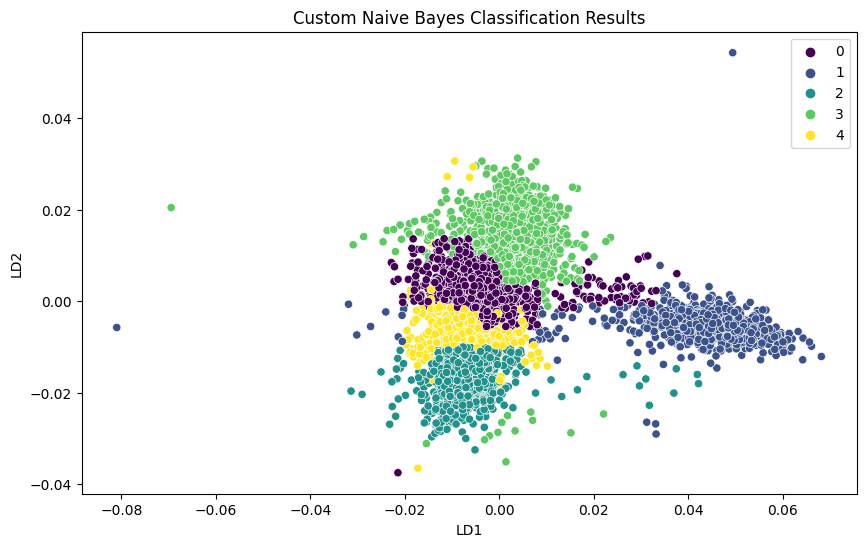

In [19]:
# WARNING: This code is a placeholder and should be replaced with the final implementation by Bogdan.
# Plotting the LDA projection and the classification results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=custom_nb_predictions, palette='viridis')
plt.title('Custom Naive Bayes Classification Results')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()


**Cross validation and picking number of components**

Best number of components: 4
Best CV accuracy score: 0.7921


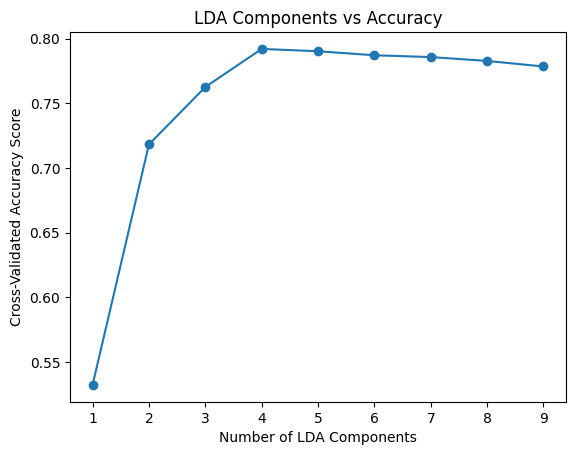

In [21]:
# Cross Validation for LDA Custom
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


def cross_validate_lda(X, y, n_components_list, cv=5):
    kf = KFold(n_splits=cv)
    scores = []

    for n_components in n_components_list:
        fold_scores = []
        for train_index, test_index in kf.split(X):
            # Split the data into training and test for the current fold
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Initialize your custom LDA with the current number of components
            lda = LDA_Custom(n_components=n_components)
            
            # Fit the LDA and transform the training data
            X_train_lda = lda.fit_transform(X_train_fold, y_train_fold)
            
            # Transform the test data
            X_test_lda = lda.transform(X_test_fold)

            # Fit the classifier to the LDA-transformed training data
            classifier = custom_nb
            classifier.fit(X_train_lda, y_train_fold)

            # Predict on the transformed test data
            y_pred = classifier.predict(X_test_lda)

            # Calculate the accuracy for the current fold and n_components
            fold_scores.append(accuracy_score(y_test_fold, y_pred))

        # Store the average score for the current n_components
        scores.append(np.mean(fold_scores))

    # Get the number of components with the best average score
    best_n_components = n_components_list[np.argmax(scores)]
    best_score = np.max(scores)

    return best_n_components, best_score, scores

# Define the range of n_components you want to test
n_components_range = range(1, 10)  # or any other range you deem appropriate

# Perform cross-validation
best_n_components, best_score, all_scores = cross_validate_lda(X_train, y_train, n_components_range)

# Output the results
print(f'Best number of components: {best_n_components}')
print(f'Best CV accuracy score: {best_score}')

# Optionally, plot the scores
import matplotlib.pyplot as plt
plt.plot(list(n_components_range), all_scores, marker='o')
plt.xlabel('Number of LDA Components')
plt.ylabel('Cross-Validated Accuracy Score')
plt.title('LDA Components vs Accuracy')
plt.show()


n_components: 1
  Training accuracy: 0.5532
  Test accuracy: 0.5296

n_components: 2
  Training accuracy: 0.7548
  Test accuracy: 0.7086

n_components: 3
  Training accuracy: 0.8121
  Test accuracy: 0.7538

n_components: 4
  Training accuracy: 0.8546
  Test accuracy: 0.7922

n_components: 5
  Training accuracy: 0.8519
  Test accuracy: 0.7904

n_components: 6
  Training accuracy: 0.8475
  Test accuracy: 0.7886

n_components: 7
  Training accuracy: 0.8426
  Test accuracy: 0.7836

n_components: 8
  Training accuracy: 0.8443
  Test accuracy: 0.7802

n_components: 9
  Training accuracy: 0.8349
  Test accuracy: 0.7764



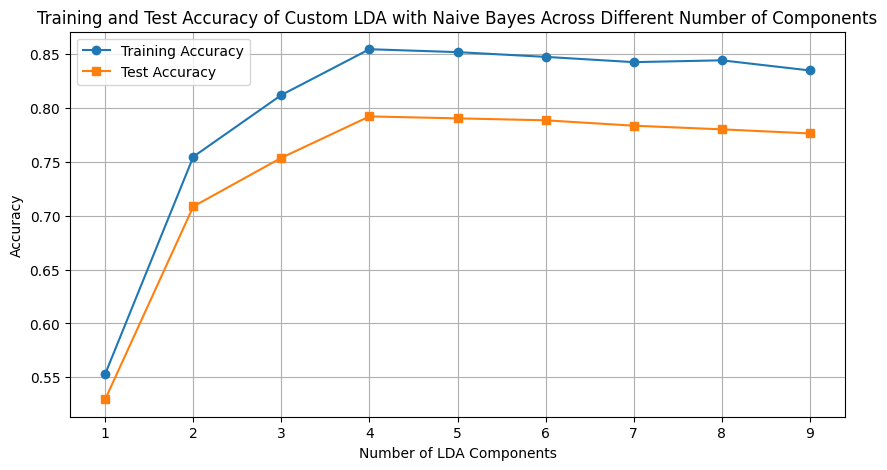

In [26]:
# Initialize your custom LDA model
lda_custom = LDA_Custom()

# Placeholders for accuracies
train_accuracies = []
test_accuracies = []

# Test for n_components from 1 to 5
for n_components in range(1, 10):
    # Fit LDA on the training data with the current number of components
    lda_custom.n_components = n_components
    lda_custom.fit(X_train, y_train)
    
    # Transform the training data
    X_train_lda = lda_custom.transform(X_train)
    
    # Transform the test data
    X_test_lda = lda_custom.transform(X_test)
    
    # Train the classifier on the LDA-transformed training data
    classifier = custom_nb
    classifier.fit(X_train_lda, y_train)
    
    # Predict on the training data
    y_train_pred = classifier.predict(X_train_lda)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)
    
    # Predict on the test data
    y_test_pred = classifier.predict(X_test_lda)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Print the accuracies for each number of components
for i, (train_acc, test_acc) in enumerate(zip(train_accuracies, test_accuracies), start=1):
    print(f'n_components: {i}')
    print(f'  Training accuracy: {train_acc}')
    print(f'  Test accuracy: {test_acc}\n')

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, 10), test_accuracies, marker='s', label='Test Accuracy')
plt.title('Training and Test Accuracy of Custom LDA with Naive Bayes Across Different Number of Components')
plt.xlabel('Number of LDA Components')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Training vs Test Accuracy:**
- With one LDA component, the model's performance is notably limited on both the training and test sets, indicating underfitting.
- Increasing to two components results in a substantial increase in both training and test accuracies. This suggests that the second component captures significant additional information that is relevant for class separation.
- Three components continue the trend of improving performance, suggesting that the third component also captures meaningful information.
- At four components, we observe the highest test accuracy, indicating that the fourth component contributes positively to the model's ability to generalize to unseen data. Meanwhile, the training accuracy continues to increase, which is expected as the model becomes more complex and better fitted to the training data.
- The introduction of the fifth component, however, does not improve the test accuracy and even slightly diminishes it. This could suggest that the fifth component may be capturing noise or redundant information, which does not generalize well, a potential sign of overfitting.

**Overfitting Analysis:**
- Overfitting is typically indicated by a large discrepancy between training and test accuracies. For one to three components, we see a reasonable gap between training and test results, with the gap narrowing as more components are added.
- The four-component model yields the best test accuracy, with the training accuracy being higher but not excessively so, which suggests that while the model is fitting well to the training data, it is not overfitting.
- With the fifth component, despite the training accuracy being high, the slight decrease in test accuracy could be an early sign of overfitting, as the model begins to learn aspects of the training data that do not generalize to the test data.

**Conclusion:**
The choice of four components is the most justified because it maximizes test accuracy, indicating good generalization, without showing signs of overfitting. This is the key objective of a predictive model: to perform well on unseen data. Additional components beyond this point do not enhance and may even degrade the model's performance on the test set, suggesting that they do not add valuable discriminative information. Thus, four LDA components seem to capture the most relevant features of the data for the classification task at hand, striking a balance between capturing sufficient complexity and avoiding the pitfalls of overfitting.

In [ ]:
# Save the model
pickle.dump(custom_nb, open('custom_nb.pkl', 'wb'))

**SVM Classifier**

In [ ]:
# Training the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicting and evaluating the SVM model
y_pred_svm = svm_model.predict(X_test)
print("SVM Classifier Report")
print(classification_report(y_test, y_pred_svm))

In [ ]:
# save the model
pickle.dump(svm_model, open('svm_model.pkl', 'wb'))

## Models Evaluation and Comparison

In [ ]:
# Load the SVM and Naive Bayes models
svm_model = pickle.load(open('svm_model.pkl', 'rb'))
nb_model = pickle.load(open('custom_nb.pkl', 'rb'))

# Load the CNN model
cnn_model = load_model('cnn_model.h5')

In [ ]:
# Generate predictions
svm_predictions = svm_model.predict(X_test)
nb_predictions = nb_model.predict(X_test_lda)
cnn_predictions = cnn_model.predict(X_test_reshaped)
cnn_predictions = cnn_predictions.argmax(axis=1)

In [ ]:
# Dictionary to hold model predictions
model_predictions = {
    'SVM': svm_predictions,
    'Custom Naive Bayes': nb_predictions,
    'CNN': cnn_predictions
}

# DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Compute and store metrics
for model_name, predictions in model_predictions.items():
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_test, predictions, average='weighted', zero_division=0)
    f1 = f1_score(y_test, predictions, average='weighted', zero_division=0)
    metrics_df.loc[model_name] = [accuracy, precision, recall, f1]

metrics_df

**Confusion Matrix**

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_confusion_matrix(y_test, svm_predictions, 'SVM', axes[0])
plot_confusion_matrix(y_test, nb_predictions, 'Custom Naive Bayes', axes[1])
plot_confusion_matrix(y_test, cnn_predictions, 'CNN', axes[2])
plt.tight_layout()
plt.show()

**ROC-AUC Plot**

In [ ]:
# Initialize and fit the SVM model with probability estimates enabled
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Function to plot ROC curves
def plot_roc_curve(y_true, y_pred_scores, model_name, ax):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    ax.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')
    ax.set_title(f'ROC for {model_name}')
    ax.set_xlabel('False Positive Rate')

    
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

nb_pred_scores = nb_model.predict_proba(X_test_lda)
cnn_pred_scores = cnn_model.predict(X_test_reshaped)
svm_pred_scores = svm_model.predict_proba(X_test)

# Plotting ROC curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plot_roc_curve(y_test_binarized, nb_pred_scores, 'Custom Naive Bayes', axes[0])
plot_roc_curve(y_test_binarized, cnn_pred_scores, 'CNN', axes[1])
plot_roc_curve(y_test_binarized, svm_pred_scores, 'SVM', axes[2])
plt.tight_layout()
plt.show()

1. **SVM Model:**
   - Class 0 has a high true positive count (817) with some misclassifications mainly with class 4.
   - Classes 1, 2, and 3 also show high true positive counts with some confusion between them.
   - Class 4 has the most false positives, indicating some misclassification issues.

2. **Custom Naive Bayes Model:**
   - Class 1 and class 3 seem to have a very high number of true positives, especially class 1 which has 900, indicating strong performance for these classes.
   - However, classes 0 and 4 show substantial confusion, with class 4 particularly having many false negatives (314).

3. **CNN Model:**
   - Classes 0 and 1 have very high true positive rates with minimal misclassification.
   - Class 3 shows excellent classification with 943 true positives.
   - Class 4, similar to the SVM model, has the highest number of false positives.

**Conclusion:**
Based on the confusion matrices, the CNN model appears to be the most accurate, with high true positive rates and fewer misclassifications across all classes. The SVM model also performs well but has more misclassifications compared to the CNN. The Custom Naive Bayes model seems to have significant misclassification issues, particularly for classes 0 and 4. The CNN model would be the recommended choice due to its superior performance in correctly classifying the different classes with fewer errors.

## Challenges and Limitations



## Future Directions

- There are several promising directions for future research based on the findings of this project. Exploring alternative dimensionality reduction methods, such as non-linear techniques or deep learning-based approaches, could offer more flexibility in handling complex datasets. Improving computational efficiency, possibly through optimized algorithms or cloud-based computing, would make processing large datasets more feasible. Experimentation with different classification models and advanced hyperparameter optimization could further enhance model accuracy. Finally, applying these techniques to varied datasets would help validate their effectiveness across different domains and use cases

## Conclusion

- Our project underscored the importance of dimensionality reduction in machine learning, particularly in enhancing model performance and uncovering meaningful patterns in the data. Despite facing computational and methodological challenges, our use of LDA and PCA provided valuable insights into the data and improved the performance of our SVM model. The project highlighted both the potential and the limitations of these techniques, offering a nuanced view of their application in machine learning. Future work, building on the lessons learned and exploring new directions, promises to further refine and expand the utility of dimensionality reduction in this rapidly evolving field.

## References

- Jolliffe, I. T. "Principal Component Analysis." Springer, 2002.
- Blei, D. M., Ng, A. Y., & Jordan, M. I. "Latent Dirichlet Allocation." Journal of Machine Learning Research, 2003.
- Cortes, C., & Vapnik, V. "Support-Vector Networks." Machine Learning, 1995.
- Scikit-learn Documentation: Dimensionality Reduction. [Online]. Available: https://scikit-learn.org/stable/modules/decomposition.html
- Pedregosa et al. "Scikit-learn: Machine Learning in Python." JMLR, 2011.
- James, G., Witten, D., Hastie, T., & Tibshirani, R. "An Introduction to Statistical Learning." Springer, 2013.
- Bishop, C. M. "Pattern Recognition and Machine Learning." Springer, 2006.
- Goodfellow, I., Bengio, Y., & Courville, A. "Deep Learning." MIT Press, 2016.
- Scikit-learn User Guide: Machine Learning in Python. [Online]. Available: https://scikit-learn.org/stable/user_guide.html
- TensorFlow Documentation: An End-to-End Open Source Machine Learning Platform. [Online]. Available: https://www.tensorflow.org/overview